In [1]:
import os
import json
import polars as pl

# Název složky, kde jsou uloženy JSON soubory s testy
directory_path = 'parsed_tests'

# Seznam pro ukládání všech otázek ze všech souborů
all_questions = []


# Procházení všech souborů v dané složce
print(f"Prohledávám složku: '{directory_path}'...")
for filename in os.listdir(directory_path):
    # Zpracováváme pouze soubory s příponou .json
    if filename.endswith('.json'):
        file_path = os.path.join(directory_path, filename)

        # Otevření a načtení JSON souboru
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)

                # Získání data testu
                test_date = data.get('datum_testu')
                questions = data.get('prehled_otazek', [])

                # Přidání data testu ke každé otázce a přidání do celkového seznamu
                for question in questions:
                    question['datum_testu'] = test_date
                    all_questions.append(question)

            except json.JSONDecodeError:
                print(f"Chyba při parsování souboru: {filename}")
            except Exception as e:
                print(f"Naskytla se neočekávaná chyba u souboru {filename}: {e}")


# Vytvoření Polars DataFrame ze seznamu všech otázek
if all_questions:
    df = pl.DataFrame(all_questions)

    # Převedení sloupce 'moznosti' z dict na struct pro lepší manipulaci v Polars
    # a datum_testu na datový typ Date
    df = df.with_columns(
        pl.col("moznosti").cast(pl.Struct([
            pl.Field("A", pl.Utf8),
            pl.Field("B", pl.Utf8),
            pl.Field("C", pl.Utf8)
        ])),
        pl.col("datum_testu").str.to_date("%d.%m.%Y", strict=False)
    )

    # Zobrazení prvních několika řádků a schématu DataFrame
    print("\nÚspěšně načteno a zpracováno:")
    print(f"Celkový počet otázek: {len(df)}")
    print("\nSchéma DataFrame:")
    print(df.schema)
else:
    print("\nNebyly nalezeny žádné otázky k načtení.")


print(f"Testy v rozsahu: {max(df['datum_testu'])} - {min(df['datum_testu'])}")
EXPORT_datetime_range = f"{min(df['datum_testu']).strftime('%Y-%m-%d')}_to_{max(df['datum_testu']).strftime('%Y-%m-%d')}"
df

Prohledávám složku: 'parsed_tests'...

Úspěšně načteno a zpracováno:
Celkový počet otázek: 544698

Schéma DataFrame:
Schema({'text_otazky': String, 'moznosti': Struct({'A': String, 'B': String, 'C': String}), 'spravna_odpoved': String, 'body': Int64, 'datum_testu': Date})
Testy v rozsahu: 2025-09-24 - 2025-04-15


text_otazky,moznosti,spravna_odpoved,body,datum_testu
str,struct[3],str,i64,date
"""Co je to inklinace?""","{""je to úhel mezi zeměpisným a magnetickým severem"",""je to úhel, o který by se sklonila magnetka kompasu, pokud by na ní nebylo závažíčko"",""je to úhel chyby kompasu""}","""B""",1,2025-04-19
"""Údržba letadla je:""","{""souhrn činností zajišťující pevnost letadla systémem prohlídek, ošetření a oprav"",""souhrn činností zajišťujících zachování způsobilosti k leteckému provozu systémem prohlídek, ošetření a oprav"",""souhrn činností zajišťujících čistotu všech částí letadla""}","""B""",1,2025-04-19
"""Šrouby upevnění vrtule musí bý…","{""stačí pouze jeden šroub"",""zajištěny proti povolení"",""nemusejí být zajištěny""}","""B""",3,2025-04-19
"""Letíme kursem 030°, točíme pra…","{""na 180°"",""na 150°"",""na 210°""}","""C""",0,2025-04-19
"""Zasunutím vzdušných brzd se:""","{""zvětší klouzavost i minimální rychlost letu"",""zvětší klouzavost a umožní to použití menší minimální rychlosti"",""zmenší klouzavost, minimální rychlost letu se zvětší""}","""B""",0,2025-04-19
…,…,…,…,…
"""Jak se změní rychlost proudění…","{""rychlost se zvýší, statický tlak klesne"",""rychlost se zvýší, statický tlak se zvýší"",""rychlost klesne, statický tlak klesne""}","""A""",0,2025-09-24
"""Je povinností pilota, mít při …","{""není když má GPS"",""je"",""není""}","""B""",0,2025-09-24
"""225 stupňů je vedlejší světová…","{""jihovýchod"",""jihozápad"",""severozápad""}","""B""",0,2025-09-24


In [2]:
# Seskupení podle textu otázky a provedení agregace pro ostatní sloupce
df_grouped = df.group_by("text_otazky").agg(
    # Spočítáme, kolikrát se každá otázka vyskytla
    pl.len().alias("pocet_vyskytu"),

    # Pro sloupce, které by měly být pro danou otázku vždy stejné, vezmeme první výskyt
    pl.col("moznosti").first().alias("moznosti"),
    pl.col("spravna_odpoved").first().alias("spravna_odpoved"),

    # Vezmeme MAXIMÁLNÍ hodnotu bodů, abychom se "zbavili" nul, pokud existuje i nenulová varianta
    pl.col("body").max().alias("body"),

    # Zaznamenáme, zda pro danou otázku existovala i varianta s 0 body
    (pl.col("body") == 0).any().alias("obsahuje_variantu_s_0_body"),

    # NOVÝ SLOUPEC: Zjistíme datum, kdy se otázka objevila úplně poprvé
    pl.col("datum_testu").min().alias("první_výskyt"),

    # UPRAVENÝ SLOUPEC: Zjistíme datum, kdy se otázka objevila naposledy
    pl.col("datum_testu").max().alias("poslední_výskyt")

).sort("pocet_vyskytu", descending=True) # Seřadíme výsledek podle četnosti

# Zobrazení výsledného unikátního a agregovaného DataFrame
print("Byl vytvořen nový DataFrame 'df_grouped' s unikátními otázkami.")
print(f"Původní počet záznamů: {len(df)}")
print(f"Nový počet unikátních otázek: {len(df_grouped)}")

df_grouped

Byl vytvořen nový DataFrame 'df_grouped' s unikátními otázkami.
Původní počet záznamů: 544698
Nový počet unikátních otázek: 664


text_otazky,pocet_vyskytu,moznosti,spravna_odpoved,body,obsahuje_variantu_s_0_body,první_výskyt,poslední_výskyt
str,u32,struct[3],str,i64,bool,date,date
"""Do jaké výšky lze počítat s „p…",7404,"{""u ULLa do výšky přibližně 20 m"",""do výšky 1 m"",""asi do výšky jako je polovina rozpětí křídla""}","""C""",1,true,2025-04-15,2025-09-24
"""Při laminárním proudění:""",6228,"{""dochází k vzájemnému promíchávání proudnic"",""nedochází k vzájemnému promíchávání proudnic"",""dochází k vzájemnému promíchávání proudnic, ale na konci sledovaného průřezu (profilu) se v proudu netvoří víry""}","""B""",1,true,2025-04-15,2025-09-24
"""Kritický bod je:""",5221,"{""bod na plánované trati nejvíce vzdálený od VBT"",""místo na trati plánované, ze kterého je stejná časová vzdálenost do místa startu i do místa přistání"",""místo na trati kam až letadlo může doletět, aby se za současného stavu paliva mohlo vrátit""}","""B""",1,true,2025-04-15,2025-09-24
"""Zeměkoule je:""",5109,"{""ideální koule"",""síť souřadnicových čar"",""rotační elipsoid na pólech zploštělý""}","""C""",1,true,2025-04-15,2025-09-24
"""Co se rozumí pod pojmem „těžký…",3750,"{""snaha letadla překlopit se při zabrždění dozadu, tj. na zadní část trupu"",""jestliže se nos letadla při uvolnění řízení klopí nahoru (zvedá)"",""vyjádření vzájemné polohy neutrálního bodu a těžiště, v tomto případě je těžiště před neutrálním bodem""}","""B""",1,true,2025-04-15,2025-09-24
…,…,…,…,…,…,…,…
"""Mezinárodní tísňový kmitočet v…",100,"{""121,005 MHz"",""121,500 MHz"",""136,975 MHz""}","""B""",1,true,2025-09-07,2025-09-24
"""Pilot nesmí spouštět motor SLZ…",98,"{""se nepřesvědčil, že má aktivovanou ruční brzdu a zapnutá poziční světla"",""se nepřesvědčil, že před letounem je dostatečný prostor pro zastavení případného nežádoucího pohybu SLZ a je dostatečný volný prostor v blízkosti vrtule"",""se nepřesvědčil, že před letounem je dostatečný prostor pro zastavení případného nežádoucího pohybu SLZ""}","""B""",1,true,2025-09-06,2025-09-24
"""Dvojitý bílý kříž, umístěný ho…",91,"{""na letišti se provádějí výsadky"",""na letišti je kombinovaný provoz"",""na letišti je provoz kluzáků""}","""C""",1,true,2025-09-06,2025-09-23


In [3]:
import matplotlib.pyplot as plt
import os

# Zkontrolujeme, zda DataFrame 'question_counts' existuje
# (předpokládáme, že 'question_counts' je Polars DataFrame)
if 'question_counts' in locals() and question_counts is not None and len(question_counts) > 0:

    # Vybereme prvních 50 nejčastějších otázek (DataFrame by měl být již seřazen)
    top_50_questions = question_counts.head(50)

    # --- Vykreslení grafu pomocí Matplotlib.pyplot ---

    # Nastavení velikosti obrázku (šířka, výška v palcích)
    # Pro 50 otázek potřebujeme větší výšku, aby se texty vešly.
    plt.figure(figsize=(10, 15))

    # Vytvoření horizontálního sloupcového grafu
    # y: text otázky, width: počet výskytů
    bars = plt.barh(
        top_50_questions.get_column("text_otazky"),
        top_50_questions.get_column("pocet_vyskytu")
    )

    # Otočení osy y, aby byla nejčastější otázka (s nejdelším sloupcem) nahoře
    plt.gca().invert_yaxis()

    # Přidání popisků a titulku
    plt.xlabel("Počet výskytů v testech")
    plt.ylabel("Text otázky")

    # Dynamický titulek podle počtu souborů ve složce
    try:
        num_tests = len(os.listdir("parsed_tests"))
        plt.title(f"Top 50 nejčastějších otázek v {num_tests} testech", loc='left')
    except FileNotFoundError:
        plt.title("Top 50 nejčastějších otázek")


    # Přidání mřížky na osu x pro lepší čitelnost hodnot
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Přidání textových popisků s přesným počtem na konce sloupců
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.1,  # Pozice X (kousek za koncem sloupce)
            bar.get_y() + bar.get_height() / 2, # Pozice Y (uprostřed výšky sloupce)
            f'{width}', # Text, který se má zobrazit (šířka sloupce)
            va='center' # Vertikální zarovnání na střed
        )

    # Zajištění, aby se všechny popisky a texty vešly do obrázku
    plt.tight_layout()

    # Uložení grafu do souboru
    output_filename = "top_50_overall_questions.png"
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"Graf byl úspěšně uložen do souboru: {output_filename}")

    # Zobrazení grafu
    plt.show()

else:
    print("DataFrame 'question_counts' neexistuje nebo je prázdný. Spusťte nejprve buňku pro seskupení otázek.")

DataFrame 'question_counts' neexistuje nebo je prázdný. Spusťte nejprve buňku pro seskupení otázek.


In [15]:
 # filter where points is 0
EXPORT_NUMBER_OF_QUESTIONS_WITH_0_POINTS = len(df_grouped.filter(pl.col("body") == 0))

Nalezeno 23 týdnů s daty. Ukládám všechny grafy, zobrazí se pouze nejnovější...
------------------------------


/tmp/ipykernel_236273/3281899167.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("pocet_vyskytu")
/tmp/ipykernel_236273/3281899167.py:84: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Histogram pro týden od 14.04.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-15.png
Histogram pro týden od 21.04.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-16.png
Histogram pro týden od 28.04.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-17.png
Histogram pro týden od 05.05.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-18.png
Histogram pro týden od 12.05.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-19.png
Histogram pro týden od 19.05.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-20.png
Histogram pro týden od 26.05.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-21.png
Histogram pro týden od 02.06.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-22.png
Histogram pro týden od 09.06.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-23.png
Histogram pro týden od 16.06.2025 byl uložen do souboru: histogram_weeks/top50_questions_20

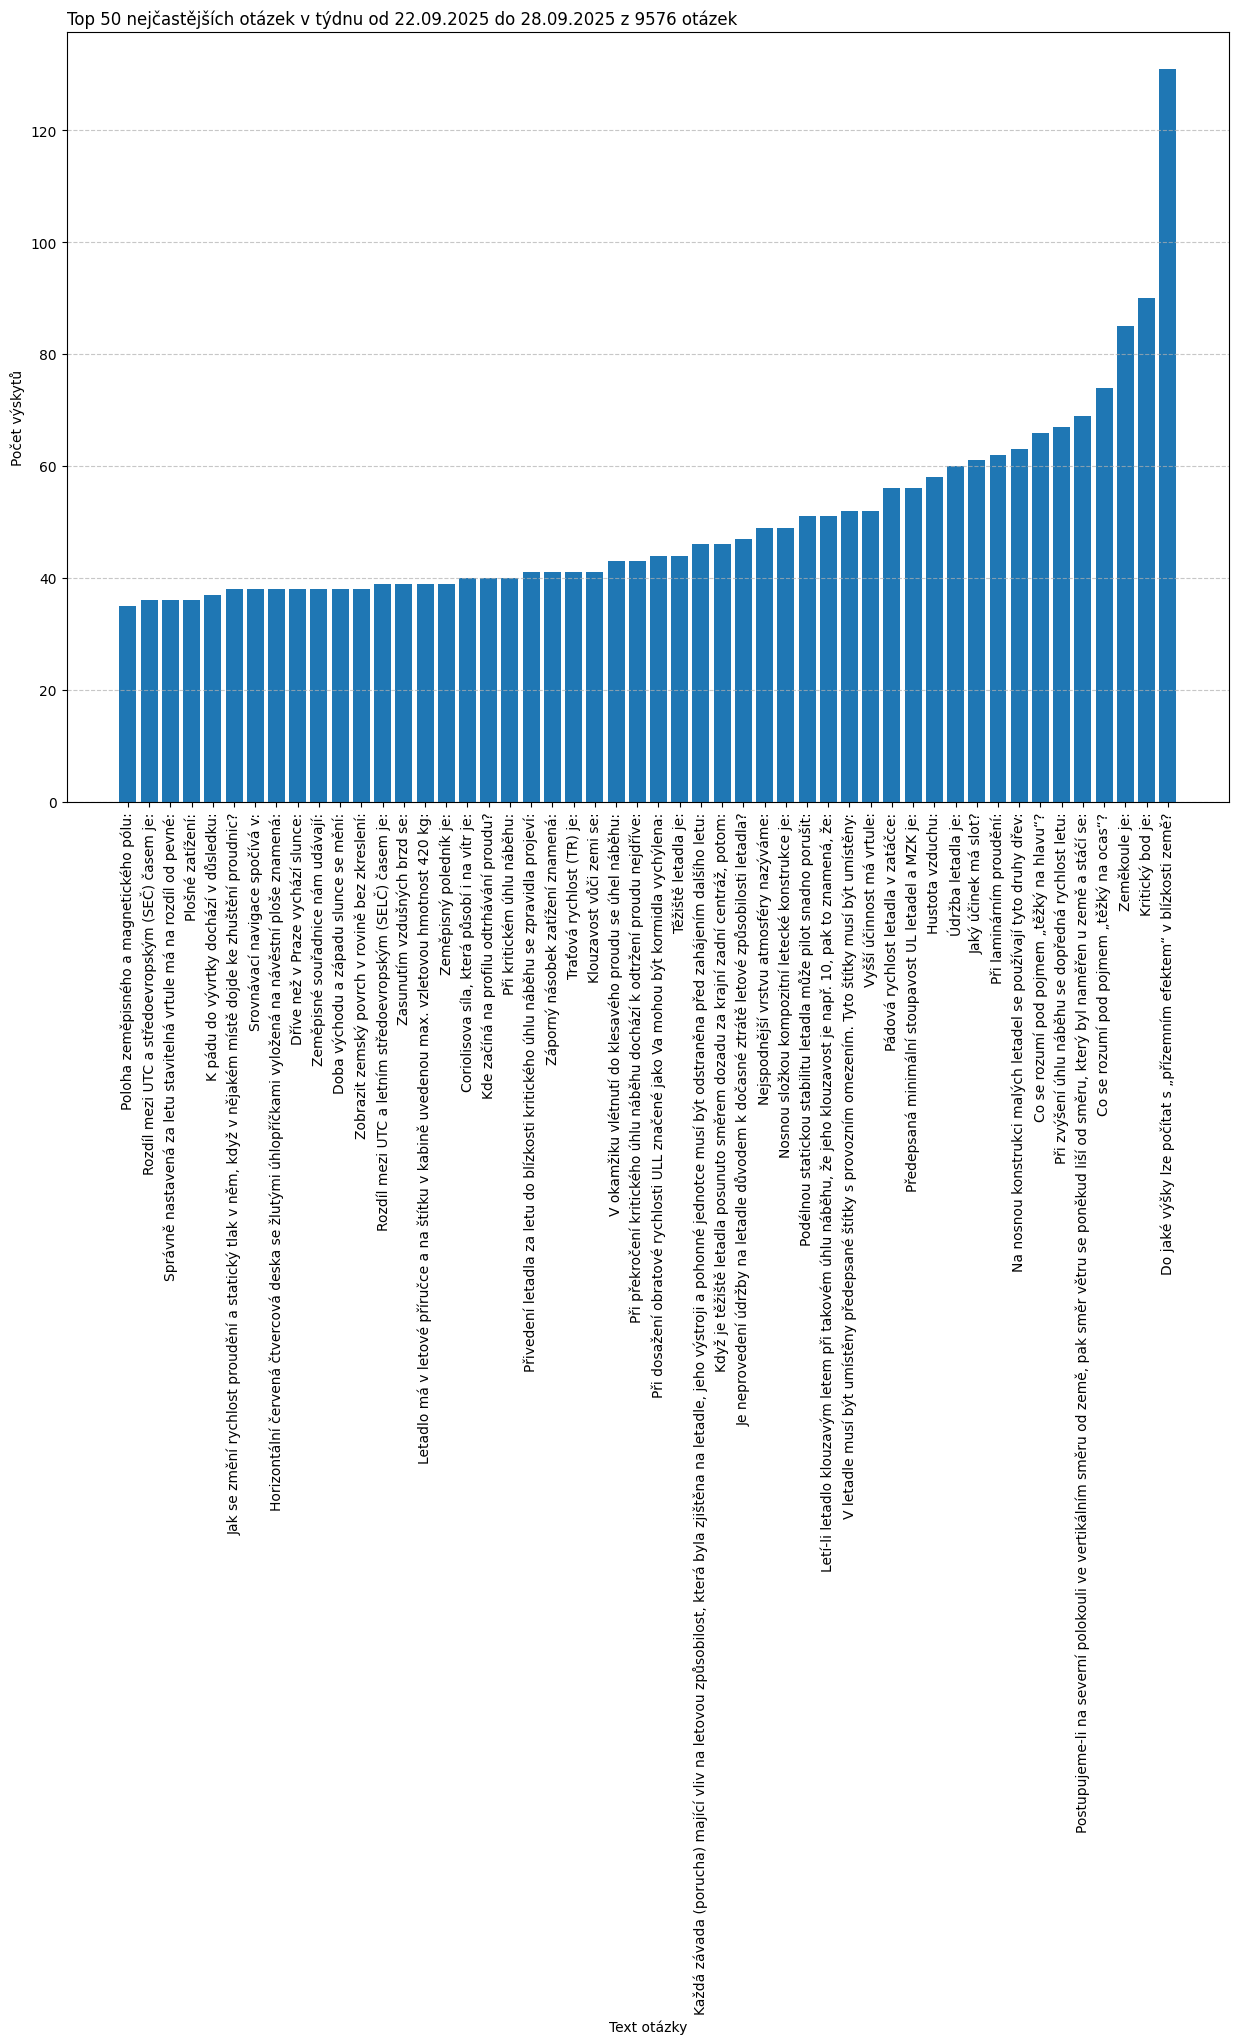

------------------------------
Proměnná 'EXPORT_newest_histogram_week' obsahuje cestu k nejnovějšímu souboru:
histogram_weeks/top50_questions_2025-38.png


In [16]:
import polars as pl
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
import os

# Potlačení varování, které může Polars vyvolat při agregacích s datovými typy
warnings.simplefilter(action='ignore', category=FutureWarning)

# Inicializace proměnné pro export
EXPORT_newest_histogram_week = None

# Zkontrolujeme, zda původní DataFrame 'df' existuje
if 'df' in locals() and df is not None and len(df) > 0:

    # 1. KROK: Přidání sloupce s týdnem
    df_with_week = df.with_columns(
        pl.col("datum_testu").dt.truncate("1w").alias("tyden")
    )

    # 2. KROK: Seskupení otázek podle týdne a textu
    weekly_counts = df_with_week.group_by("tyden", "text_otazky").agg(
        pl.count().alias("pocet_vyskytu")
    ).sort("tyden", "pocet_vyskytu", descending=[False, True])

    # 3. KROK: Získání unikátních týdnů a identifikace toho nejnovějšího
    unique_weeks = weekly_counts.get_column("tyden").unique().sort()

    if not unique_weeks.is_empty():
        # Identifikujeme nejnovější týden PŘED spuštěním smyčky
        newest_week_date = unique_weeks[-1]

        # --- Příprava na export ---
        output_directory = 'histogram_weeks'
        os.makedirs(output_directory, exist_ok=True)
        # Nastavíme exportní proměnnou na název souboru, který BUDE patřit nejnovějšímu grafu
        newest_week_filename_str = newest_week_date.strftime('%Y-%W') # Formát ROK-ČÍSLO TÝDNE
        EXPORT_newest_histogram_week = f"{output_directory}/top50_questions_{newest_week_filename_str}.png"

        print(f"Nalezeno {len(unique_weeks)} týdnů s daty. Ukládám všechny grafy, zobrazí se pouze nejnovější...")
        print("-" * 30)

        # 4. KROK: Iterace přes VŠECHNY týdny
        for week_start_date in unique_weeks:
            # Seřadíme data vzestupně, aby v grafu šly sloupce zleva (nejnižší) doprava (nejvyšší)
            top_questions_in_week_asc = weekly_counts.filter(
                pl.col("tyden") == week_start_date
            ).head(50).sort("pocet_vyskytu", descending=False)

            # Formátování dat pro titulek a název souboru pro AKTUÁLNÍ týden
            week_end_date = week_start_date + timedelta(days=6)
            start_str = week_start_date.strftime('%d.%m.%Y')
            end_str = week_end_date.strftime('%d.%m.%Y')
            week_filename_str = week_start_date.strftime('%Y-%W')
            current_filename = f"{output_directory}/top50_questions_{week_filename_str}.png"

            # --- Vykreslení grafu ---
            # Změna velikosti - širší než vyšší, aby se vešly popisky
            plt.figure(figsize=(15, 10))

            # --- ZMĚNA Z BARH NA BAR ---
            plt.bar(
                # os x: text otázky
                top_questions_in_week_asc.get_column("text_otazky"),
                # os y: počet výskytů
                top_questions_in_week_asc.get_column("pocet_vyskytu")
            )

            # --- ZMĚNA POPISKŮ OS ---
            plt.xlabel("Text otázky")
            plt.ylabel("Počet výskytů")

            # --- KLÍČOVÁ ZMĚNA: Otočení popisků osy x, aby byly čitelné ---
            plt.xticks(rotation=90)

            # Vypočítáme celkový počet otázek v daném týdnu pro titulek
            total_questions_in_week = df_with_week.filter(pl.col('tyden') == week_start_date).height
            plt.title(f"Top {len(top_questions_in_week_asc)} nejčastějších otázek v týdnu od {start_str} do {end_str} z {total_questions_in_week} otázek", loc='left')

            # --- ZMĚNA MŘÍŽKY NA OSU Y ---
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # tight_layout je zde velmi důležitý, aby se oříznuté popisky vešly do obrázku
            plt.tight_layout()

            # Uložení KAŽDÉHO grafu
            plt.savefig(current_filename, bbox_inches='tight')
            print(f"Histogram pro týden od {start_str} byl uložen do souboru: {current_filename}")

            # Zobrazení POUZE nejnovějšího grafu
            if week_start_date == newest_week_date:
                print("\n--- Zobrazuji nejnovější graf ---")
                plt.show()

            # Zavření plátna, aby se uvolnila paměť
            plt.close()

    else:
        print("Nenalezena žádná data pro generování týdenního histogramu.")
else:
    print("DataFrame 'df' neexistuje nebo je prázdný. Nejprve spusťte buňku pro načtení dat.")

# Na konci vypíšeme obsah proměnné pro kontrolu
print("-" * 30)
if EXPORT_newest_histogram_week:
    print(f"Proměnná 'EXPORT_newest_histogram_week' obsahuje cestu k nejnovějšímu souboru:")
    print(EXPORT_newest_histogram_week)
else:
    print("Proměnná 'EXPORT_newest_histogram_week' je prázdná, protože nebyl vygenerován žádný graf.")

Nalezeno 6 měsíců s daty. Ukládám všechny grafy, zobrazí se pouze nejnovější...
------------------------------


/tmp/ipykernel_236273/2458530906.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("pocet_vyskytu")
/tmp/ipykernel_236273/2458530906.py:84: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Histogram pro měsíc April 2025 byl uložen do souboru: histogram_month/top50_questions_2025-04.png
Histogram pro měsíc May 2025 byl uložen do souboru: histogram_month/top50_questions_2025-05.png
Histogram pro měsíc June 2025 byl uložen do souboru: histogram_month/top50_questions_2025-06.png
Histogram pro měsíc July 2025 byl uložen do souboru: histogram_month/top50_questions_2025-07.png
Histogram pro měsíc August 2025 byl uložen do souboru: histogram_month/top50_questions_2025-08.png
Histogram pro měsíc September 2025 byl uložen do souboru: histogram_month/top50_questions_2025-09.png

--- Zobrazuji nejnovější graf ---


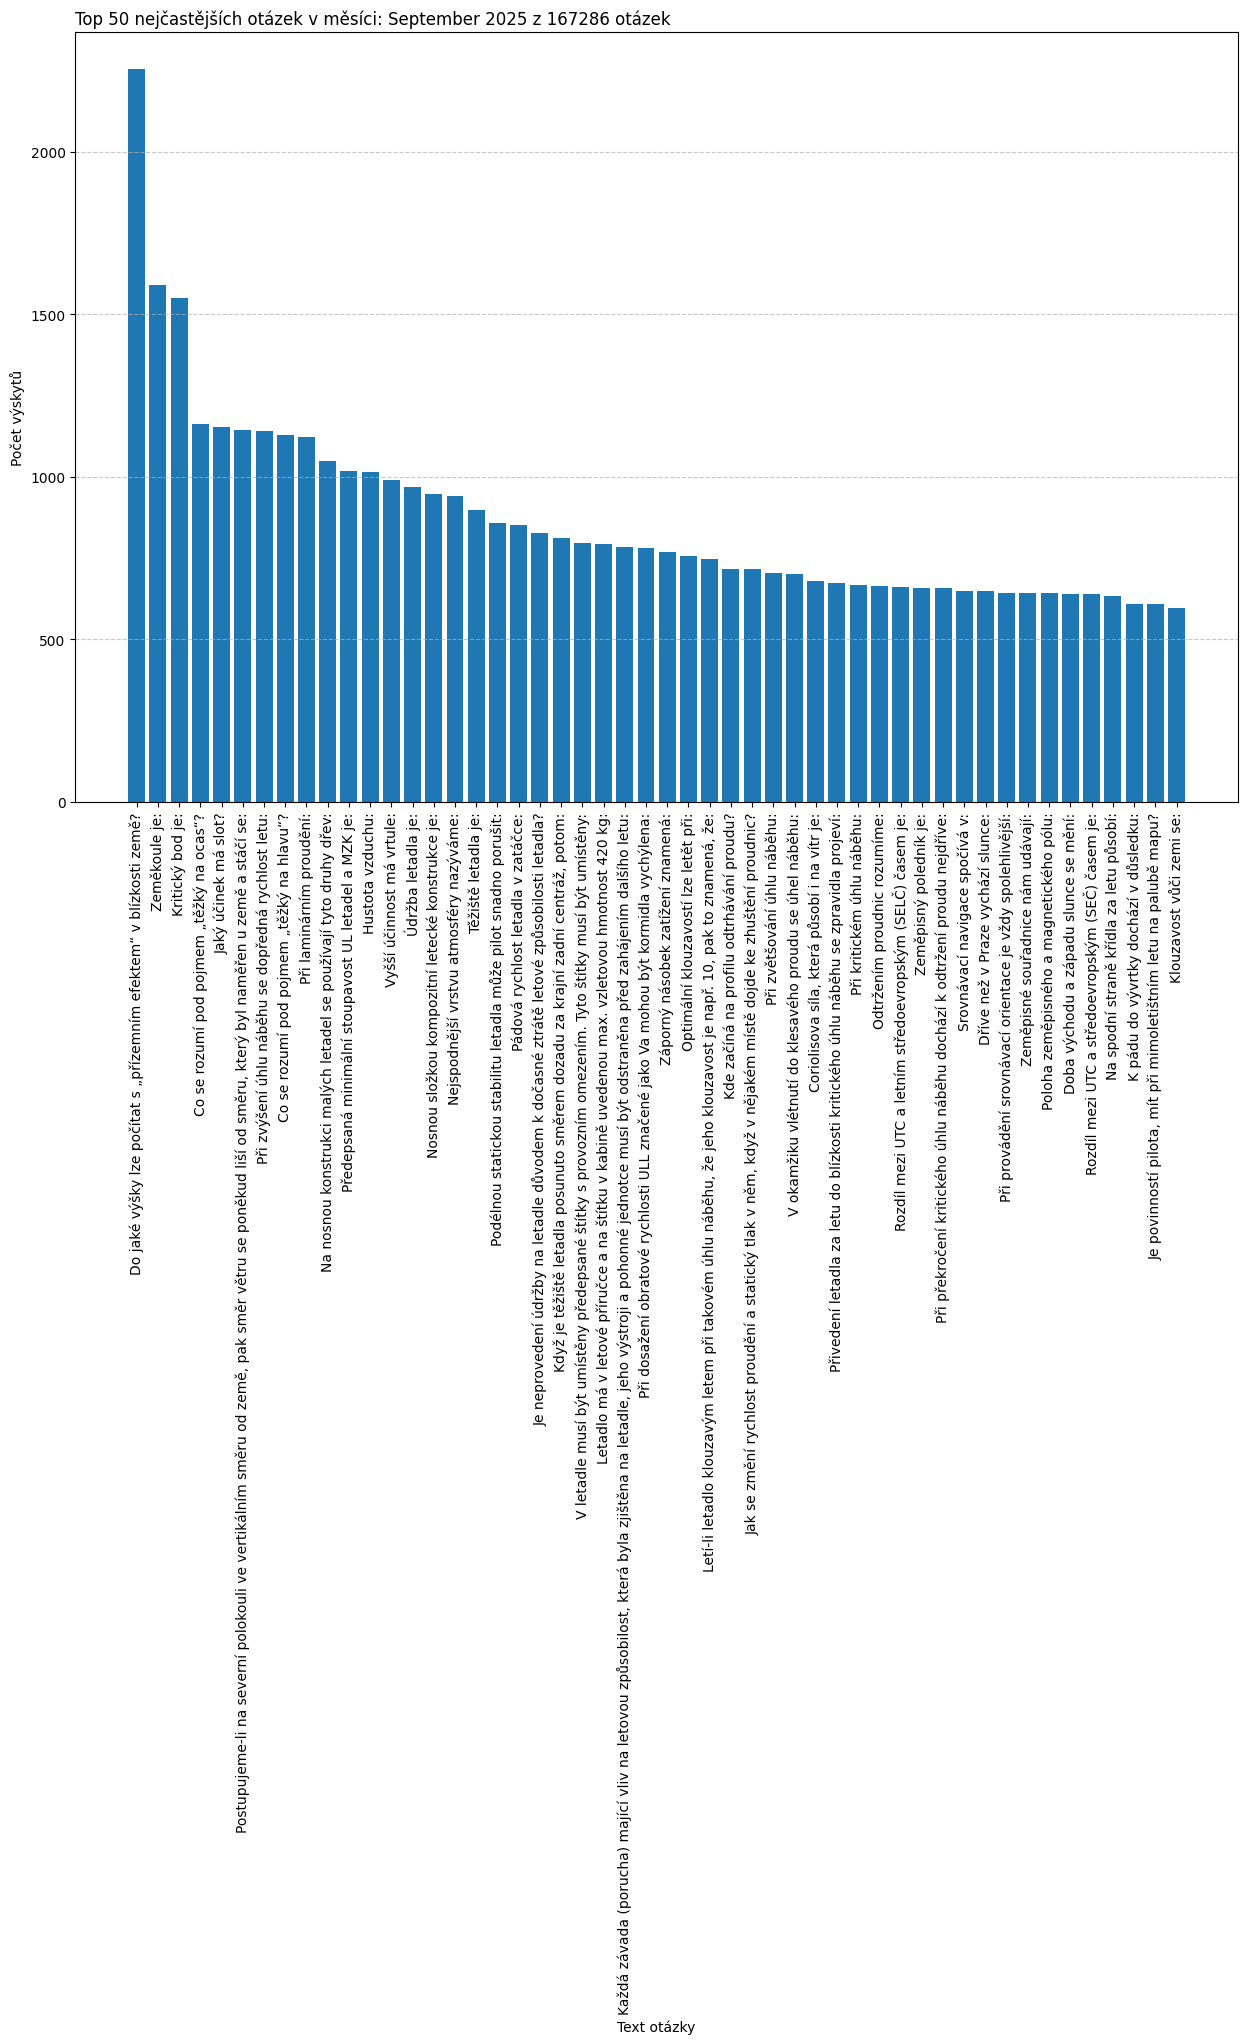

------------------------------
Proměnná 'EXPORT_newest_histogram_month' obsahuje cestu k nejnovějšímu souboru:
histogram_month/top50_questions_2025-09.png


In [17]:
import polars as pl
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
import os # Potřebujeme pro vytvoření složky

# Potlačení varování, které může Polars vyvolat při agregacích s datovými typy
warnings.simplefilter(action='ignore', category=FutureWarning)

# Inicializace proměnné pro export, pro případ, že by se graf nevytvořil
EXPORT_newest_histogram_month = None

# Zkontrolujeme, zda původní DataFrame 'df' existuje
if 'df' in locals() and df is not None and len(df) > 0:

    # 1. KROK: Přidání sloupce s měsícem
    df_with_month = df.with_columns(
        pl.col("datum_testu").dt.truncate("1mo").alias("mesic")
    )

    # 2. KROK: Seskupení otázek podle měsíce a textu
    # Data jsou seřazena sestupně, takže nejčastější otázka bude v grafu vlevo
    monthly_counts = df_with_month.group_by("mesic", "text_otazky").agg(
        pl.count().alias("pocet_vyskytu")
    ).sort("mesic", "pocet_vyskytu", descending=[False, True])

    # 3. KROK: Získání unikátních měsíců a identifikace toho nejnovějšího
    unique_months = monthly_counts.get_column("mesic").unique().sort()

    # Zkontrolujeme, zda máme vůbec nějaká data
    if not unique_months.is_empty():
        # Identifikujeme nejnovější měsíc PŘED spuštěním smyčky
        newest_month_date = unique_months[-1]

        # --- Příprava na export ---
        output_directory = 'histogram_month'
        os.makedirs(output_directory, exist_ok=True)

        # Nastavíme exportní proměnnou na název souboru, který BUDE patřit nejnovějšímu grafu
        newest_month_filename_str = newest_month_date.strftime('%Y-%m')
        EXPORT_newest_histogram_month = f"{output_directory}/top50_questions_{newest_month_filename_str}.png"

        print(f"Nalezeno {len(unique_months)} měsíců s daty. Ukládám všechny grafy, zobrazí se pouze nejnovější...")
        print("-" * 30)

        # 4. KROK: Iterace přes VŠECHNY měsíce
        for month_start_date in unique_months:
            # Pro každý měsíc vybereme příslušná data
            top_questions_in_month = monthly_counts.filter(
                pl.col("mesic") == month_start_date
            ).head(50)

            # Formátování názvu pro titulek a soubor pro AKTUÁLNÍ měsíc ve smyčce
            month_title_str = month_start_date.strftime('%B %Y')
            month_filename_str = month_start_date.strftime('%Y-%m')
            current_filename = f"{output_directory}/top50_questions_{month_filename_str}.png"

            # --- Vykreslení grafu ---
            # Změna velikosti - širší než vyšší
            plt.figure(figsize=(15, 10))

            # --- ZMĚNA NA VERTIKÁLNÍ GRAF ---
            plt.bar(
                # os x: text otázky
                top_questions_in_month.get_column("text_otazky"),
                # os y: počet výskytů
                top_questions_in_month.get_column("pocet_vyskytu")
            )

            # --- ZMĚNA POPISKŮ OS ---
            plt.xlabel("Text otázky")
            plt.ylabel("Počet výskytů")

            # --- OTOČENÍ POPISKŮ OSY X ---
            plt.xticks(rotation=90)

            total_questions_in_month = df_with_month.filter(pl.col('mesic') == month_start_date).height
            plt.title(f"Top {len(top_questions_in_month)} nejčastějších otázek v měsíci: {month_title_str} z {total_questions_in_month} otázek", loc='left')

            # --- ZMĚNA MŘÍŽKY NA OSU Y ---
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Zajištění, že se popisky vejdou
            plt.tight_layout()

            # Uložení KAŽDÉHO grafu do souboru
            plt.savefig(current_filename, bbox_inches='tight')
            print(f"Histogram pro měsíc {month_title_str} byl uložen do souboru: {current_filename}")

            # Zobrazení POUZE nejnovějšího grafu
            if month_start_date == newest_month_date:
                print("\n--- Zobrazuji nejnovější graf ---")
                plt.show()

            # Zavření plátna, aby se uvolnila paměť
            plt.close()

    else:
        print("Nenalezena žádná data pro generování histogramu.")
else:
    print("DataFrame 'df' neexistuje nebo je prázdný. Nejprve spusťte buňku pro načtení dat.")

# Na konci vypíšeme obsah proměnné pro kontrolu
print("-" * 30)
if EXPORT_newest_histogram_month:
    print(f"Proměnná 'EXPORT_newest_histogram_month' obsahuje cestu k nejnovějšímu souboru:")
    print(EXPORT_newest_histogram_month)
else:
    print("Proměnná 'EXPORT_newest_histogram_month' je prázdná, protože nebyl vygenerován žádný graf.")

Původní počet otázek: 544698
Počet otázek za 3 body: 199088
------------------------------
Nalezeno 6 měsíců s daty (za 3 body). Ukládám všechny grafy...
------------------------------


/tmp/ipykernel_236273/2969587607.py:31: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("pocet_vyskytu")
/tmp/ipykernel_236273/2969587607.py:79: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Histogram pro měsíc April 2025 (3 body) byl uložen do souboru: histogram_month_3_points/top50_questions_2025-04.png
Histogram pro měsíc May 2025 (3 body) byl uložen do souboru: histogram_month_3_points/top50_questions_2025-05.png
Histogram pro měsíc June 2025 (3 body) byl uložen do souboru: histogram_month_3_points/top50_questions_2025-06.png
Histogram pro měsíc July 2025 (3 body) byl uložen do souboru: histogram_month_3_points/top50_questions_2025-07.png
Histogram pro měsíc August 2025 (3 body) byl uložen do souboru: histogram_month_3_points/top50_questions_2025-08.png
Histogram pro měsíc September 2025 (3 body) byl uložen do souboru: histogram_month_3_points/top50_questions_2025-09.png

--- Zobrazuji nejnovější graf (3 body) ---


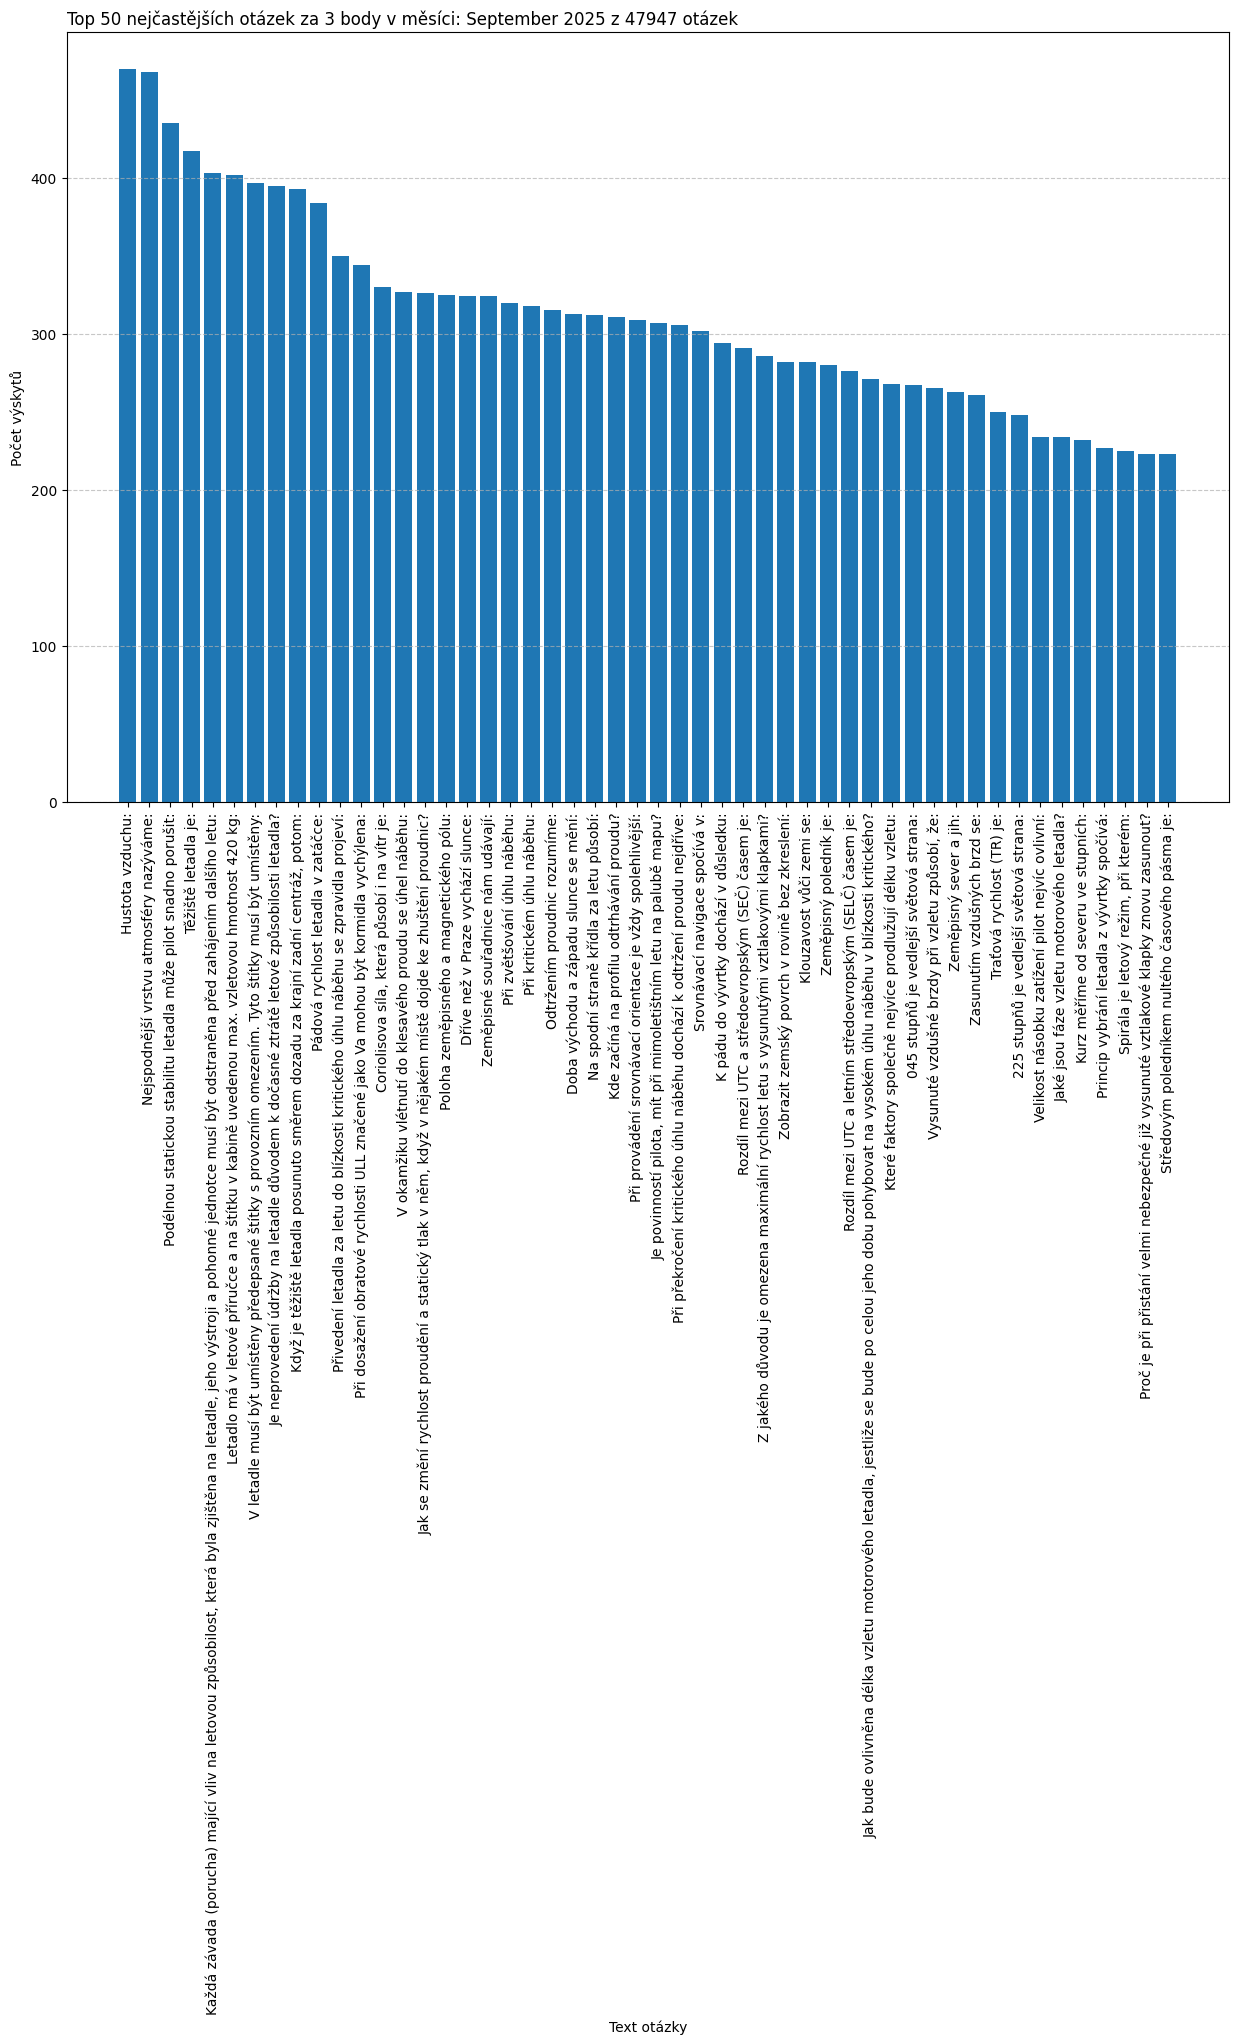

In [18]:
import polars as pl
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
import os

# Potlačení varování, které může Polars vyvolat při agregacích s datovými typy
warnings.simplefilter(action='ignore', category=FutureWarning)

EXPORT_newest_histogram_month_3P = None

# Zkontrolujeme, zda původní DataFrame 'df' existuje
if 'df' in locals() and df is not None and len(df) > 0:

    # --- KLÍČOVÁ ZMĚNA: Filtrace otázek pouze za 3 body ---
    print(f"Původní počet otázek: {len(df)}")
    df_3_points = df.filter(pl.col("body") == 3)
    print(f"Počet otázek za 3 body: {len(df_3_points)}")
    print("-" * 30)
    # ---------------------------------------------------------

    # Zkontrolujeme, zda po filtraci nějaké otázky zbyly
    if not df_3_points.is_empty():
        # 1. KROK: Přidání sloupce s měsícem (již k filtrovaným datům)
        df_with_month = df_3_points.with_columns(
            pl.col("datum_testu").dt.truncate("1mo").alias("mesic")
        )

        # 2. KROK: Seskupení otázek podle měsíce a textu
        monthly_counts = df_with_month.group_by("mesic", "text_otazky").agg(
            pl.count().alias("pocet_vyskytu")
        ).sort("mesic", "pocet_vyskytu", descending=[False, True])

        # 3. KROK: Získání unikátních měsíců a identifikace toho nejnovějšího
        unique_months = monthly_counts.get_column("mesic").unique().sort()

        if not unique_months.is_empty():
            newest_month_date = unique_months[-1]

            # --- Příprava na export ---
            # Vytvoříme novou složku pro tyto specifické grafy
            output_directory = 'histogram_month_3_points'
            os.makedirs(output_directory, exist_ok=True)

            newest_month_filename_str = newest_month_date.strftime('%Y-%m')
            EXPORT_newest_histogram_month_3P = f"{output_directory}/top50_questions_{newest_month_filename_str}.png"

            print(f"Nalezeno {len(unique_months)} měsíců s daty (za 3 body). Ukládám všechny grafy...")
            print("-" * 30)

            # 4. KROK: Iterace přes VŠECHNY měsíce
            for month_start_date in unique_months:
                top_questions_in_month = monthly_counts.filter(
                    pl.col("mesic") == month_start_date
                ).head(50)

                month_title_str = month_start_date.strftime('%B %Y')
                month_filename_str = month_start_date.strftime('%Y-%m')
                current_filename = f"{output_directory}/top50_questions_{month_filename_str}.png"

                # --- Vykreslení grafu ---
                plt.figure(figsize=(15, 10))

                plt.bar(
                    top_questions_in_month.get_column("text_otazky"),
                    top_questions_in_month.get_column("pocet_vyskytu")
                )

                plt.xlabel("Text otázky")
                plt.ylabel("Počet výskytů")
                plt.xticks(rotation=90)

                total_questions_in_month = df_with_month.filter(pl.col('mesic') == month_start_date).height

                # --- ÚPRAVA TITULKU ---
                plt.title(f"Top {len(top_questions_in_month)} nejčastějších otázek za 3 body v měsíci: {month_title_str} z {total_questions_in_month} otázek", loc='left')

                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()

                plt.savefig(current_filename, bbox_inches='tight')
                print(f"Histogram pro měsíc {month_title_str} (3 body) byl uložen do souboru: {current_filename}")

                if month_start_date == newest_month_date:
                    print("\n--- Zobrazuji nejnovější graf (3 body) ---")
                    plt.show()

                plt.close()
        else:
            print("Pro otázky za 3 body nebyla nalezena žádná data k zobrazení.")
    else:
        print("Nebyly nalezeny žádné otázky s hodnotou 3 body.")
else:
    print("DataFrame 'df' neexistuje nebo je prázdný. Nejprve spusťte buňku pro načtení dat.")


Generuji graf pro období od 25.08.2025 do 24.09.2025.
------------------------------
Nalezeno 167286 otázek v daném období.

Histogram byl uložen do souboru: histogram_last_30_days/top50_questions_newsest.png


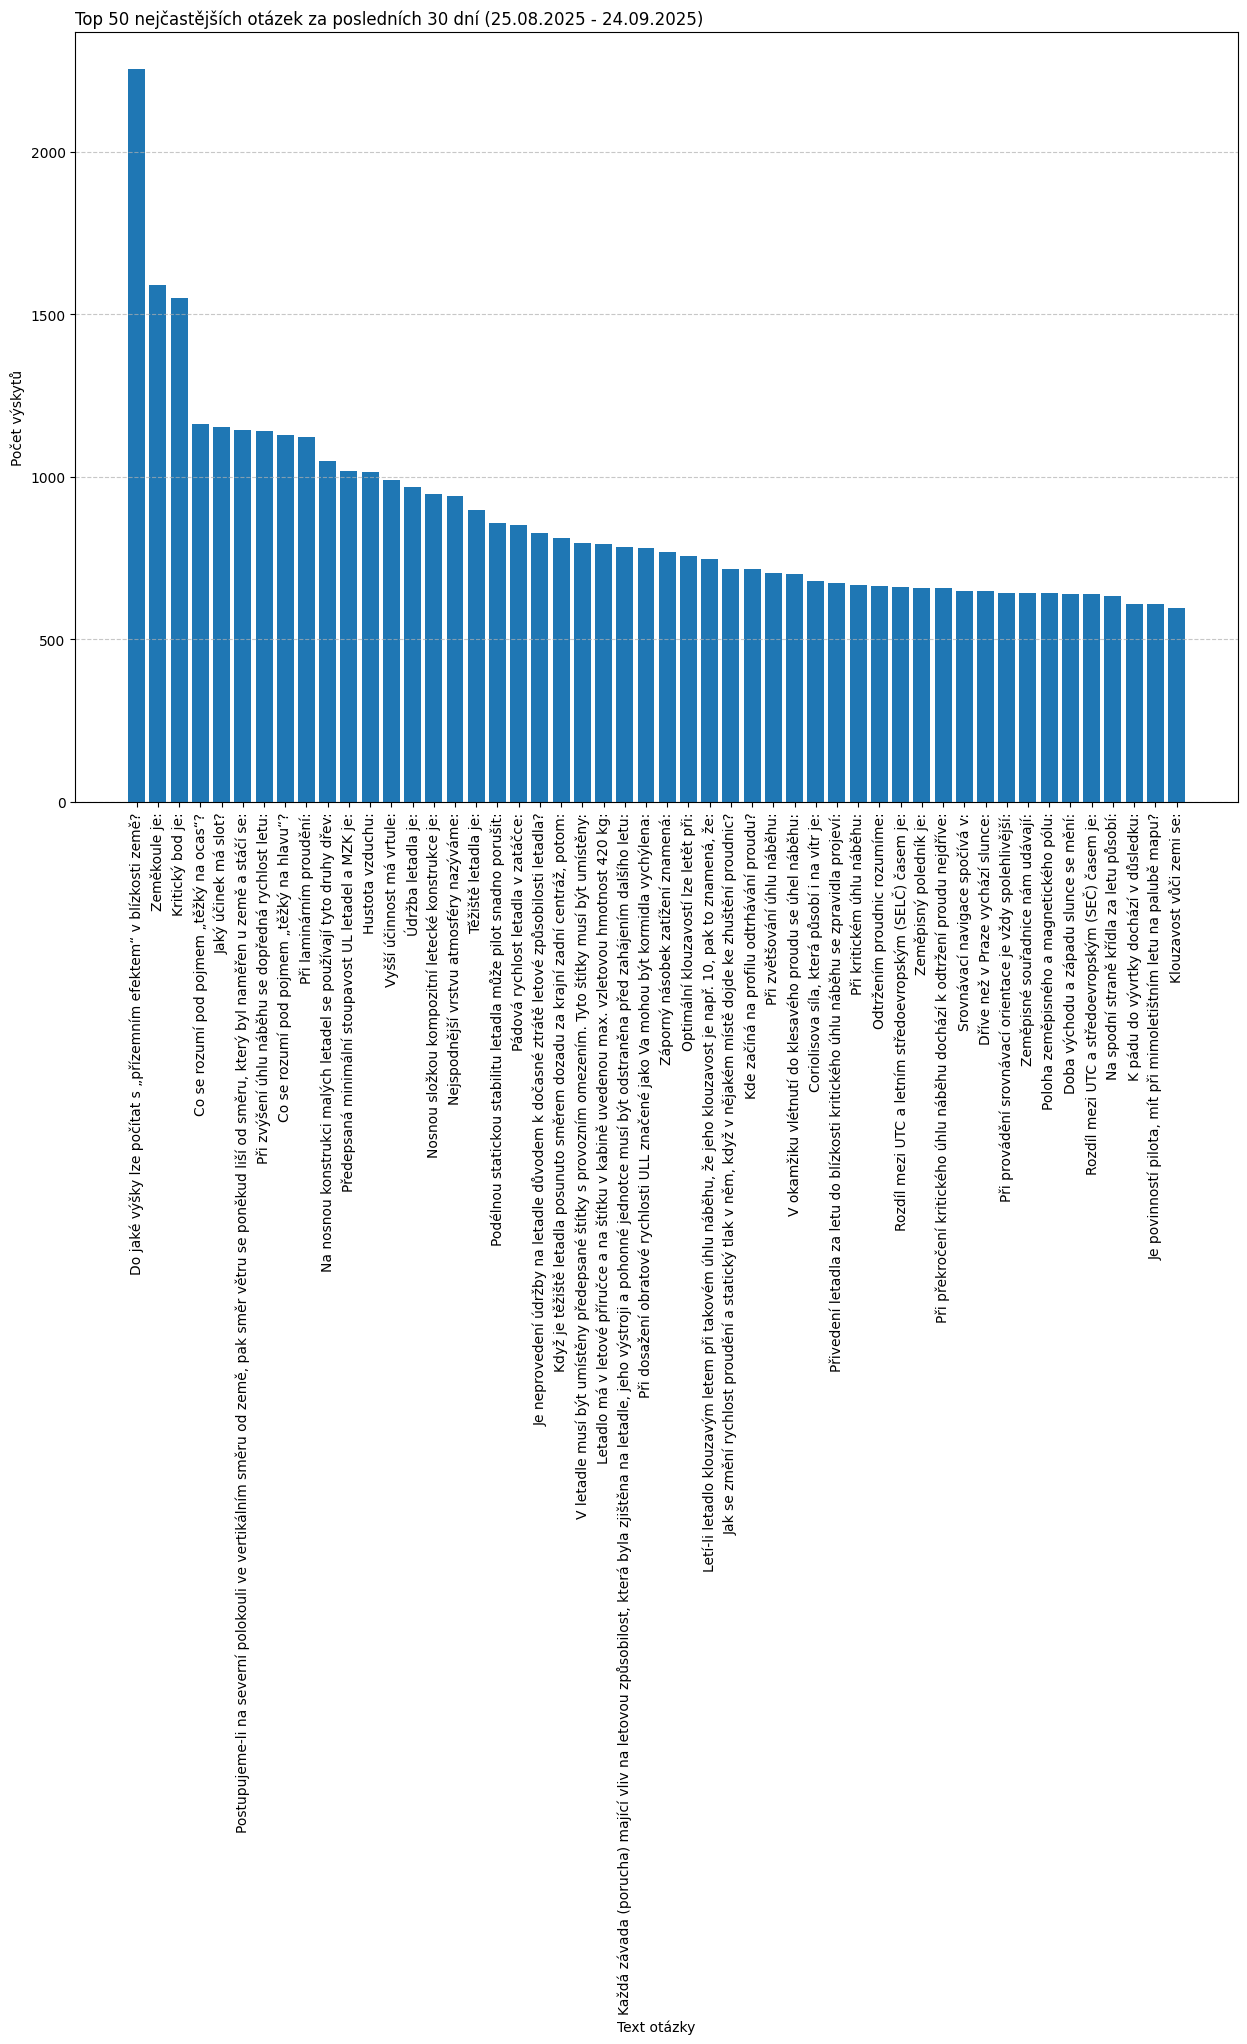

------------------------------
Proměnná 'EXPORT_last_30_days_histogram' obsahuje cestu k souboru:
histogram_last_30_days/top50_questions_newsest.png


In [19]:
import polars as pl
import matplotlib.pyplot as plt
import warnings
from datetime import date, timedelta
import os

# Potlačení varování, které může Polars vyvolat
warnings.simplefilter(action='ignore', category=FutureWarning)

# Inicializace proměnné pro export
EXPORT_last_30_days_histogram = None

# Zkontrolujeme, zda původní DataFrame 'df' existuje
if 'df' in locals() and df is not None and len(df) > 0:

    # 1. KROK: Definice časového okna (posledních 30 dní)
    today = date.today()
    start_date = today - timedelta(days=30)

    # Formátování pro titulek
    today_str = today.strftime('%d.%m.%Y')
    start_date_str = start_date.strftime('%d.%m.%Y')

    print(f"Generuji graf pro období od {start_date_str} do {today_str}.")
    print("-" * 30)

    # 2. KROK: Filtrace DataFrame na posledních 30 dní
    df_last_30_days = df.filter(
        pl.col("datum_testu").is_between(start_date, today)
    )

    # VOLITELNÉ: Pokud chcete analyzovat pouze otázky za 3 body v tomto období, odkomentujte následující řádek
    # df_last_30_days = df_last_30_days.filter(pl.col("body") == 3)

    # Zkontrolujeme, zda v daném období máme nějaká data
    if not df_last_30_days.is_empty():
        print(f"Nalezeno {df_last_30_days.height} otázek v daném období.")

        # 3. KROK: Seskupení a seřazení otázek
        question_counts = df_last_30_days.group_by("text_otazky").agg(
            pl.len().alias("pocet_vyskytu")
        ).sort("pocet_vyskytu", descending=True).head(50)

        # --- Příprava na export ---
        output_directory = 'histogram_last_30_days'
        os.makedirs(output_directory, exist_ok=True)
        filename = f"{output_directory}/top50_questions_newsest.png"
        EXPORT_last_30_days_histogram = filename

        # --- Vykreslení grafu ---
        plt.figure(figsize=(15, 10))

        plt.bar(
            question_counts.get_column("text_otazky"),
            question_counts.get_column("pocet_vyskytu")
        )

        plt.xlabel("Text otázky")
        plt.ylabel("Počet výskytů")
        plt.xticks(rotation=90)

        plt.title(f"Top {len(question_counts)} nejčastějších otázek za posledních 30 dní ({start_date_str} - {today_str})", loc='left')

        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Uložení grafu do souboru
        plt.savefig(filename, bbox_inches='tight')
        print(f"\nHistogram byl uložen do souboru: {filename}")

        # Zobrazení grafu
        plt.show()

    else:
        print("V posledních 30 dnech nebyla nalezena žádná data pro generování histogramu.")
else:
    print("DataFrame 'df' neexistuje nebo je prázdný. Nejprve spusťte buňku pro načtení dat.")

# Na konci vypíšeme obsah proměnné pro kontrolu
print("-" * 30)
if EXPORT_last_30_days_histogram:
    print(f"Proměnná 'EXPORT_last_30_days_histogram' obsahuje cestu k souboru:")
    print(EXPORT_last_30_days_histogram)
else:
    print("Proměnná 'EXPORT_last_30_days_histogram' je prázdná, protože nebyl vygenerován žádný graf.")

Budou porovnány následující měsíce:
- June 2025
- July 2025
- August 2025
- September 2025
------------------------------


/tmp/ipykernel_236273/574757130.py:44: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  data_for_plot = monthly_counts.filter(



Porovnávací histogram byl uložen do souboru: histogram_comparative/comparative_top20_2025-09.png


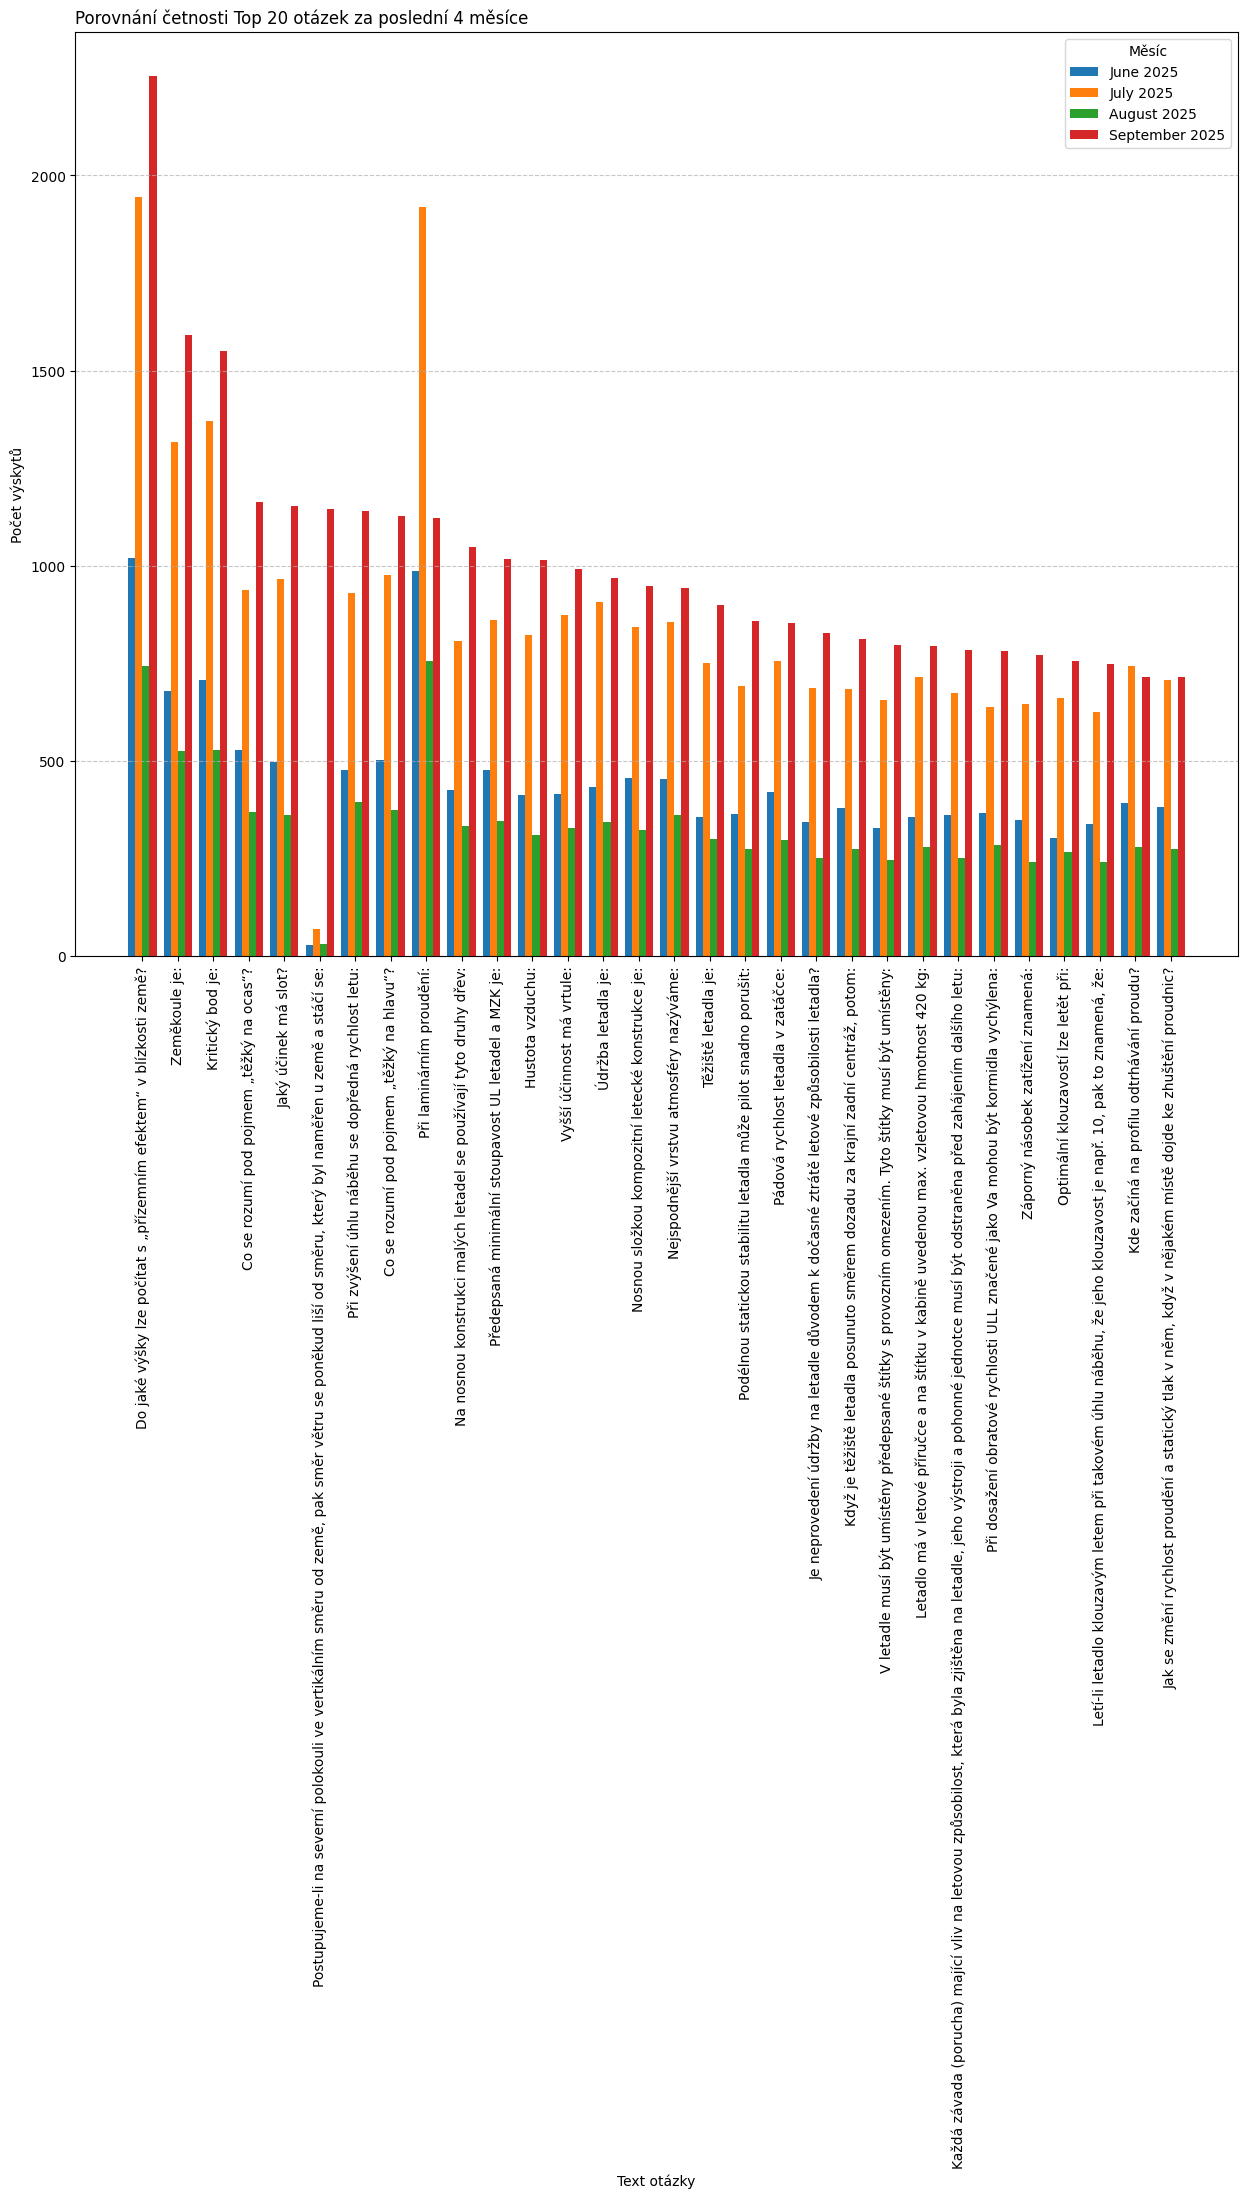

------------------------------
Proměnná 'EXPORT_comparative_histogram' obsahuje cestu k souboru:
histogram_comparative/comparative_top20_2025-09.png


In [20]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import date
import os

# Potlačení varování
warnings.simplefilter(action='ignore', category=FutureWarning)

# Inicializace proměnné pro export
EXPORT_comparative_histogram = None

# Zkontrolujeme, zda původní DataFrame 'df' existuje
if 'df' in locals() and df is not None and len(df) > 0:

    # 1. KROK: Přidání sloupce s měsícem a výpočet četností
    df_with_month = df.with_columns(
        pl.col("datum_testu").dt.truncate("1mo").alias("mesic")
    )
    # OPRAVA (Deprecation): pl.count() -> pl.len()
    monthly_counts = df_with_month.group_by("mesic", "text_otazky").agg(
        pl.len().alias("pocet_vyskytu")
    )

    # 2. KROK: Identifikace posledních 4 měsíců
    unique_months = monthly_counts.get_column("mesic").unique().sort(descending=True)

    if len(unique_months) >= 4:
        last_4_months = unique_months.head(4).sort(descending=False)
        newest_month = last_4_months[-1]

        print("Budou porovnány následující měsíce:")
        for m in last_4_months:
            print(f"- {m.strftime('%B %Y')}")
        print("-" * 30)

        # 3. KROK: Výběr 20 nejčastějších otázek z NEJNOVĚJŠÍHO měsíce
        top_20_questions_text = monthly_counts.filter(
            pl.col("mesic") == newest_month
        ).sort("pocet_vyskytu", descending=True).head(30).get_column("text_otazky")

        # 4. KROK: Příprava dat pro graf - PIVOT tabulka
        data_for_plot = monthly_counts.filter(
            pl.col("text_otazky").is_in(top_20_questions_text) &
            pl.col("mesic").is_in(last_4_months)
        )

        # OPRAVA (Deprecation): columns -> on
        pivot_df = data_for_plot.pivot(
            index="text_otazky",
            on="mesic",
            values="pocet_vyskytu"
        ).fill_null(0)

        # ----------- OPRAVA CHYBY (ShapeError) -----------
        # Převedeme názvy sloupců (které jsou typu datum) na řetězce
        column_rename_map = {
            col: col.strftime('%Y-%m-%d')
            for col in pivot_df.columns if isinstance(col, date)
        }
        pivot_df = pivot_df.rename(column_rename_map)

        # Nyní použijeme řetězec pro jednoznačné seřazení
        newest_month_str = newest_month.strftime('%Y-%m-%d')
        pivot_df = pivot_df.sort(by=newest_month_str, descending=True)
        # ----------------------------------------------------

        # 5. KROK: Vykreslení skupinového sloupcového grafu
        question_labels = pivot_df.get_column("text_otazky")
        # Pro vykreslení použijeme seznam řetězců s názvy sloupců
        month_columns_str = [m.strftime('%Y-%m-%d') for m in last_4_months]
        num_months = len(month_columns_str)

        x_positions = np.arange(len(question_labels))
        bar_width = 0.20

        plt.figure(figsize=(15, 12))

        for i, month_str in enumerate(month_columns_str):
            offset = i - (num_months - 1) / 2
            positions = x_positions + offset * bar_width

            # Zkontrolujeme, zda sloupec existuje (pro případ chybějícího měsíce jako červenec)
            if month_str in pivot_df.columns:
                counts = pivot_df.get_column(month_str)
                label = last_4_months[i].strftime('%B %Y')
                plt.bar(positions, counts, width=bar_width, label=label)
            else:
                # Pokud měsíc v datech chybí, vykreslíme pro něj nulové sloupce
                counts = [0] * len(question_labels)
                label = last_4_months[i].strftime('%B %Y')
                plt.bar(positions, counts, width=bar_width, label=label)

        # --- Finální úpravy grafu ---
        plt.xlabel("Text otázky")
        plt.ylabel("Počet výskytů")
        plt.xticks(x_positions, question_labels, rotation=90)
        plt.title(f"Porovnání četnosti Top 20 otázek za poslední 4 měsíce", loc='left')
        plt.legend(title="Měsíc")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # --- Uložení a zobrazení ---
        output_directory = 'histogram_comparative'
        os.makedirs(output_directory, exist_ok=True)
        filename = f"{output_directory}/comparative_top20_{newest_month.strftime('%Y-%m')}.png"
        EXPORT_comparative_histogram = filename

        plt.savefig(filename, bbox_inches='tight')
        print(f"\nPorovnávací histogram byl uložen do souboru: {filename}")
        plt.show()

    else:
        print("Není k dispozici dostatek dat (alespoň 4 měsíce) pro porovnání.")
else:
    print("DataFrame 'df' neexistuje nebo je prázdný. Nejprve spusťte buňku pro načtení dat.")

# Na konci vypíšeme obsah proměnné pro kontrolu
print("-" * 30)
if EXPORT_comparative_histogram:
    print(f"Proměnná 'EXPORT_comparative_histogram' obsahuje cestu k souboru:")
    print(EXPORT_comparative_histogram)
else:
    print("Proměnná 'EXPORT_comparative_histogram' je prázdná, protože nebyl vygenerován žádný graf.")

In [21]:
# generation the list of questions with zero points



In [22]:
# generation of readme file

output_readme_text = f"""# Analýza četnosti otázek v testech

> [!WARNING]
> **Upozornění:** Tato analýza je čistě informativní a je vytvořena z veřejně dostupných dat. V žádném případě neslouží jako oficiální statistika a neměla by být zneužita k jakémukoliv ovlivňování či zkreslování výsledků reálných testů.

---

## Souhrnné statistiky

*   **Analyzované období:** {EXPORT_datetime_range}
*   **Celkový počet zpracovaných testů:** {len(os.listdir("parsed_tests"))}
*   **Celkový počet otázek v datech:** {len(df)}
*   **Počet unikátních otázek:** {len(df_grouped)}
*   **Počet unikátních otázek s neznámým počtem bodů:** {EXPORT_NUMBER_OF_QUESTIONS_WITH_0_POINTS}

---

## Top 50 nejčastějších otázek (celkově)
Graf ukazuje 50 otázek, které se nejčastěji vyskytovaly napříč všemi zpracovanými testy.

![Top 50 nejčastějších otázek celkově](./top_50_overall_questions.png)

## Top 50 nejčastějších otázek (poslední celý týden)
Četnost otázek v posledním týdnu, pro který byla nalezena data.

![Top 50 otázek z nejnovějšího týdne](./{EXPORT_newest_histogram_week})

## Top 50 nejčastějších otázek (poslední měsíc)
Četnost otázek v posledním měsíci, pro který byla nalezena data.

![Top 50 otázek z nejnovějšího měsíce](./{EXPORT_newest_histogram_month})

## Top 50 nejčastějších otázek za 3 body (poslední měsíc)
Stejná analýza jako výše, ale aplikovaná pouze na otázky s bodovým hodnocením 3.

![Top 50 otázek za 3 body z nejnovějšího měsíce](./{EXPORT_newest_histogram_month_3P})

## Top 50 nejčastějších otázek (posledních 30 dní)
Graf ukazuje četnost otázek v plovoucím okně posledních 30 dní od data generování reportu.

![Top 50 otázek z posledních 30 dní]({EXPORT_last_30_days_histogram})

## Porovnání četnosti Top 20 otázek (poslední 4 měsíce)
Tento graf ukazuje vývoj četnosti 20 nejčastějších otázek z posledního měsíce v čase. Umožňuje sledovat, zda se některé otázky stávají více či méně frekventované.

![Porovnání četnosti Top 20 otázek za poslední 4 měsíce](./{EXPORT_comparative_histogram})


Všechny otázky jsou v [souboru](QUESTIONS.md)


Otázky u který není známo za kolik jsou bodů:


"""




with open("README.md", "w", encoding="utf-8") as f:
    f.write(output_readme_text)



In [23]:
import polars as pl

# Zkontrolujeme, zda DataFrame 'df_grouped' existuje
if 'df_grouped' in locals() and df_grouped is not None and len(df_grouped) > 0:

    # --- NOVÝ KROK: Seřazení DataFrame podle požadavků ---
    # 1. Primární řazení: sestupně podle sloupce 'poslední_výskyt' (nejnovější nahoře)
    # 2. Sekundární řazení: sestupně podle sloupce 'body' (nejvíce bodů nahoře)
    df_sorted = df_grouped.sort(
        "poslední_výskyt", "body", descending=[True, True]
    )
    # -----------------------------------------------------

    # Seznamy pro uložení formátovaných bloků pro oba soubory
    formatted_questions_with_ans_list = []
    formatted_questions_no_ans_list = []

    # Iterace přes NOVĚ SEŘAZENÝ DataFrame
    for row in df_sorted.iter_rows(named=True):

        # 1. Získání základních informací z řádku
        text_otazky = row['text_otazky']
        moznosti = row['moznosti']
        spravna_odpoved = row['spravna_odpoved']
        body = row['body']
        pocet_vyskytu = row['pocet_vyskytu']
        prvni_vyskyt = row['první_výskyt'].strftime('%d.%m.%Y')
        posledni_vyskyt = row['poslední_výskyt'].strftime('%d.%m.%Y')

        # 2. Sestavení textu pro jednotlivé možnosti (pro oba soubory zároveň)
        options_text_list_with_ans = []
        options_text_list_no_ans = []

        # Procházíme možnosti (A, B, C) seřazené podle abecedy
        for key in sorted(moznosti.keys()):
            option_text = moznosti[key]

            # Vytvoření řádku bez zvýrazněné odpovědi
            line_no_ans = f"- {key}) {option_text}"
            options_text_list_no_ans.append(line_no_ans)

            # Zkontrolujeme, zda je aktuální možnost ta správná
            if key == spravna_odpoved:
                line_with_ans = f"- **{key}) {option_text}**"
            else:
                line_with_ans = f"- {key}) {option_text}"
            options_text_list_with_ans.append(line_with_ans)

        # Spojení jednotlivých možností do textových bloků
        all_options_with_ans = "\n".join(options_text_list_with_ans)
        all_options_no_ans = "\n".join(options_text_list_no_ans)

        # 3. Sestavení finálního bloku pro jednu otázku (společný základ)
        question_metadata = f"*Body: {body} | Počet výskytů: {pocet_vyskytu} | Poprvé viděno: {prvni_vyskyt} | Naposledy viděno: {posledni_vyskyt}*"

        question_block_with_ans = f"""### {text_otazky}
{question_metadata}

{all_options_with_ans}"""

        question_block_no_ans = f"""### {text_otazky}
{question_metadata}

{all_options_no_ans}"""

        formatted_questions_with_ans_list.append(question_block_with_ans)
        formatted_questions_no_ans_list.append(question_block_no_ans)

    # 4. Spojení všech bloků otázek do jednoho velkého stringu pro každý soubor
    string_all_with_ans = "\n\n---\n\n".join(formatted_questions_with_ans_list)
    string_all_no_ans = "\n\n---\n\n".join(formatted_questions_no_ans_list)

    # 5. Vytvoření finálního obsahu pro oba Markdown soubory
    md_header = f"# Seznam všech unikátních otázek v datech\n\nCelkem unikátních otázek: **{len(df_grouped)}**\n\n---"
    # Poznámka: Ujistěte se, že proměnná EXPORT_NUMBER_OF_QUESTIONS_WITH_0_POINTS existuje
    if 'EXPORT_NUMBER_OF_QUESTIONS_WITH_0_POINTS' in locals():
         md_header = f"# Seznam všech unikátních otázek v datech\n\nCelkem unikátních otázek: **{len(df_grouped)}**\n\n  **Počet unikátních otázek s neznámým počtem bodů:** {EXPORT_NUMBER_OF_QUESTIONS_WITH_0_POINTS} \n\n---"


    questions_with_ans_md = f"{md_header}\n\n{string_all_with_ans}"
    questions_no_ans_md = f"{md_header}\n\n{string_all_no_ans}"

    # 6. Uložení do souborů
    output_filename_with_ans = "QUESTIONS_WITH_ANS.md"
    with open(output_filename_with_ans, "w", encoding="utf-8") as f:
        f.write(questions_with_ans_md)

    output_filename_no_ans = "QUESTIONS.md"
    with open(output_filename_no_ans, "w", encoding="utf-8") as f:
        f.write(questions_no_ans_md)

    print("Byly úspěšně vygenerovány dva soubory se správným seřazením:")
    print(f"- S odpověďmi: {output_filename_with_ans}")
    print(f"- Bez odpovědí: {output_filename_no_ans}")

else:
    print("DataFrame 'df_grouped' neexistuje nebo je prázdný. Nejprve spusťte buňku pro seskupení dat.")

Byly úspěšně vygenerovány dva soubory se správným seřazením:
- S odpověďmi: QUESTIONS_WITH_ANS.md
- Bez odpovědí: QUESTIONS.md


In [26]:
import polars as pl
import json
from datetime import date, datetime

# Protože standardní JSON formát nerozumí datovým typům jako je datum,
# vytvoříme si jednoduchou "pomocnou" třídu, která datum převede na text (string)
# ve standardizovaném ISO formátu (např. "2025-09-05").
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (datetime, date)):
            return obj.isoformat()
        return super().default(obj)

# Zkontrolujeme, zda DataFrame 'df_grouped' existuje a není prázdný
if 'df_grouped' in locals() and df_grouped is not None and len(df_grouped) > 0:

    # 1. KROK: Výběr sloupců, které chceme exportovat
    # Tím zajistíme správné pořadí a obsah finálního souboru.
    data_to_export = df_grouped.select([
        "text_otazky",
        "moznosti",
        "spravna_odpoved",
        "body",
        "pocet_vyskytu",
        "poslední_výskyt",
        "první_výskyt"
    ])

    # 2. KROK: Převod DataFrame na seznam slovníků (list of dictionaries)
    # Toto je standardní formát, se kterým knihovna 'json' nejlépe pracuje.
    questions_list = data_to_export.to_dicts()

    # 3. KROK: Uložení seznamu slovníků do JSON souboru
    output_filename = "unikatni_otazky.json"

    try:
        with open(output_filename, "w", encoding="utf-8") as f:
            # json.dump uloží data do souboru 'f'
            # ensure_ascii=False zajistí správné zobrazení české diakritiky
            # indent=4 vytvoří hezky formátovaný, odsazený soubor pro lepší čitelnost
            # cls=CustomEncoder použije naši pomocnou třídu pro převod data
            json.dump(questions_list, f, ensure_ascii=False, indent=4, cls=CustomEncoder)

        print(f"Data o unikátních otázkách byla úspěšně uložena do souboru: {output_filename}")

    except Exception as e:
        print(f"Nastala chyba při ukládání souboru: {e}")

else:
    print("DataFrame 'df_grouped' neexistuje nebo je prázdný. Nejprve spusťte buňku pro seskupení dat.")

Data o unikátních otázkách byla úspěšně uložena do souboru: unikatni_otazky.json


In [25]:
import subprocess

subprocess.call(['pandoc', 'QUESTIONS_WITH_ANS.md',  '-o', 'QUESTIONS_WITH_ANS.pdf', "-V", "geometry:margin=1in"])
subprocess.call(['pandoc', 'QUESTIONS.md',  '-o', 'QUESTIONS.pdf',"-V", "geometry:margin=1in"])
subprocess.call(['pandoc', 'README.md',  '-o', 'README.pdf', "-V", "geometry:margin=1in"])


[WARNING] [makePDF] LaTeX Warning: Float too large for page by 23.93472pt on
  input line 122.
[WARNING] [makePDF] LaTeX Warning: Float too large for page by 23.93472pt on
  input line 133.
[WARNING] [makePDF] LaTeX Warning: Float too large for page by 23.93472pt on
  input line 145.
[WARNING] [makePDF] LaTeX Warning: Float too large for page by 23.93472pt on
  input line 157.
[WARNING] [makePDF] LaTeX Warning: Float too large for page by 23.95308pt on
  input line 170.


0